## omega vs pwm

Reading data... Press Ctrl+C to stop.
PWM: 45.0, Gz: -0.32 deg/s
PWM: 50.0, Gz: -0.31 deg/s
PWM: 55.0, Gz: -0.3 deg/s
PWM: 60.0, Gz: -0.29 deg/s
PWM: 65.0, Gz: -0.27 deg/s
PWM: 70.0, Gz: 0.37 deg/s
PWM: 75.0, Gz: 4.2 deg/s
PWM: 0.0, Gz: -0.28 deg/s
PWM: 5.0, Gz: -0.29 deg/s
PWM: 10.0, Gz: -0.29 deg/s
PWM: 15.0, Gz: -0.28 deg/s
PWM: 20.0, Gz: -0.28 deg/s
PWM: 25.0, Gz: -0.28 deg/s
PWM: 30.0, Gz: -0.28 deg/s
PWM: 35.0, Gz: -0.27 deg/s
PWM: 40.0, Gz: -0.28 deg/s
PWM: 45.0, Gz: -0.27 deg/s
PWM: 50.0, Gz: -0.27 deg/s
PWM: 55.0, Gz: -0.28 deg/s
PWM: 60.0, Gz: -0.27 deg/s
PWM: 65.0, Gz: -0.29 deg/s
PWM: 70.0, Gz: -0.29 deg/s
PWM: 75.0, Gz: 0.19 deg/s
PWM: 80.0, Gz: 9.39 deg/s
PWM: 85.0, Gz: 12.23 deg/s
Stopped reading.


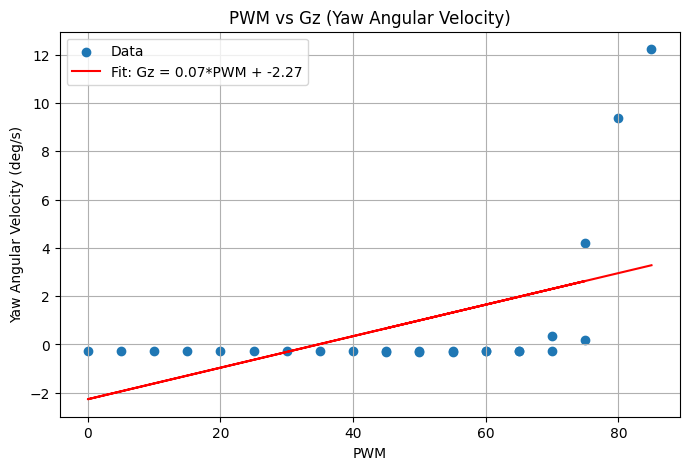

Estimated: Gz = 0.0653 * PWM + -2.2670


In [3]:
import serial
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# --- Serial Port Setup ---
PORT = 'COM14'  # Change this to your Bluetooth COM port
BAUD_RATE = 9600

ser = serial.Serial(PORT, BAUD_RATE, timeout=2)
time.sleep(2)  # wait for serial to stabilize

# --- Read Data ---
data = []
print("Reading data... Press Ctrl+C to stop.")

try:
    while True:
        line = ser.readline().decode('utf-8').strip()
        if line.startswith("PWM") or "Sweep complete" in line:
            continue  # Skip header and footer
        if ',' in line:
            try:
                pwm, gz = map(float, line.split(","))
                data.append((pwm, gz))
                print(f"PWM: {pwm}, Gz: {gz} deg/s")
            except:
                pass
except KeyboardInterrupt:
    print("Stopped reading.")

ser.close()

# --- Convert to DataFrame ---
df = pd.DataFrame(data, columns=["PWM", "Gz_deg_per_sec"])
df.to_csv("gyro_pwm_sweep.csv", index=False)

# --- Plot & Fit ---
plt.figure(figsize=(8,5))
plt.scatter(df["PWM"], df["Gz_deg_per_sec"], label="Data")

X = df[["PWM"]]
y = df["Gz_deg_per_sec"]
model = LinearRegression().fit(X, y)

y_pred = model.predict(X)
plt.plot(df["PWM"], y_pred, color="red", label=f"Fit: Gz = {model.coef_[0]:.2f}*PWM + {model.intercept_:.2f}")
plt.xlabel("PWM")
plt.ylabel("Yaw Angular Velocity (deg/s)")
plt.title("PWM vs Gz (Yaw Angular Velocity)")
plt.grid(True)
plt.legend()
plt.show()

# Print model equation
print(f"Estimated: Gz = {model.coef_[0]:.4f} * PWM + {model.intercept_:.4f}")


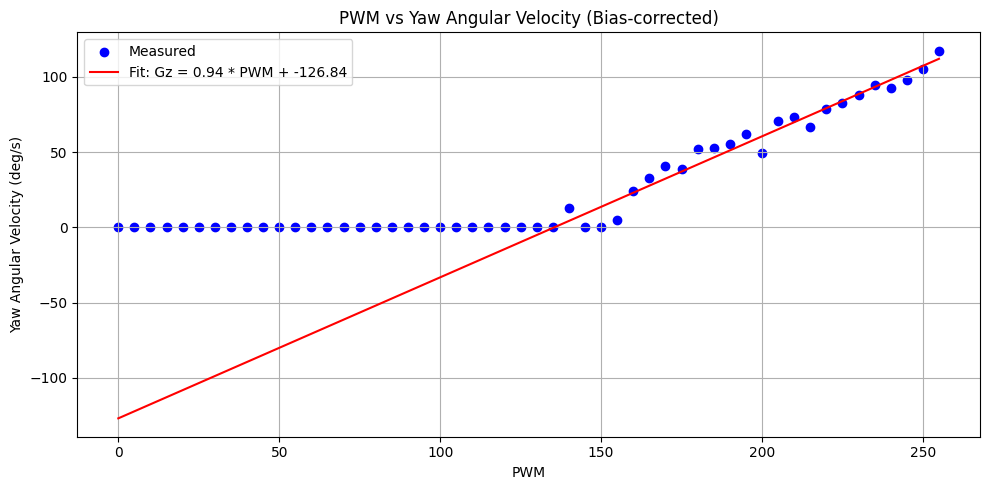

Linear Fit Equation: Gz = 0.9368 * PWM + -126.8446


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Data (bias-subtracted and pre-135 PWM Gz set to 0)
pwm_vals = [
    0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130,
    135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255
]

gz_vals = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0.06, 12.88, 0.19, 0.54, 4.71, 24.34, 33.06, 40.77, 39.07, 51.84, 53.08, 55.46, 62.23, 49.49, 70.39, 73.62, 66.86,
    78.43, 82.93, 87.98, 94.32, 92.87, 97.96, 105.36, 117.42
]

# Convert to numpy arrays
X = np.array(pwm_vals).reshape(-1, 1)
y = np.array(gz_vals)

# Fit linear model only to post-threshold values (PWM ≥ 135)
fit_mask = X.flatten() >= 135
X_fit = X[fit_mask]
y_fit = y[fit_mask]

model = LinearRegression().fit(X_fit, y_fit)
slope = model.coef_[0]
intercept = model.intercept_
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(pwm_vals, gz_vals, label="Measured", color='blue')
plt.plot(pwm_vals, y_pred, label=f"Fit: Gz = {slope:.2f} * PWM + {intercept:.2f}", color='red')
plt.xlabel("PWM")
plt.ylabel("Yaw Angular Velocity (deg/s)")
plt.title("PWM vs Yaw Angular Velocity (Bias-corrected)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print regression result
print(f"Linear Fit Equation: Gz = {slope:.4f} * PWM + {intercept:.4f}")


# 좋다.
set minimum rpm to 155.